# FINAL PROJECT: ISM 6562 - BIG DATA FOR BUSINESS

## **Setup Steps**

> ⚠️ **Note:** You must have a Java Development Kit (JDK) installed and the `JAVA_HOME` environment variable correctly configured.

- **For Windows**: The stable JDK version as of May 3, 2025, is **Java 11**.  
- **For macOS**: The stable version is **Java 17**, available from [Adoptium](https://adoptium.net/).

### 📦 Ensure All Required Packages Are Installed
Automatically installs missing Python packages using pip. This is useful for making your notebook portable and reproducible on other systems.

In [217]:
import importlib.util
import subprocess
import sys

# List of packages to ensure are installed
packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "ucimlrepo",
    "pyspark",
    "scikit-learn",       # scikit-learn's import name is 'sklearn'
    "findspark"
]

for package in packages:
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")


numpy is already installed.
pandas is already installed.
matplotlib is already installed.
seaborn is already installed.
ucimlrepo is already installed.
pyspark is already installed.
Installing scikit-learn...
findspark is already installed.


### 📚 Import Libraries
Load all necessary Python and PySpark libraries for data manipulation, visualization, and machine learning pipeline construction.

In [218]:
# Importing libraries
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StandardScaler, PCA

sns.set_theme(palette="viridis")

### ⚙️ Initialize Spark and Confirm Environment
Finds and initializes the Spark environment using `findspark`, printing the Spark installation path to confirm.

In [219]:
findspark.init() 
# If you have a SPARK_HOME environment variable set, it might find it automatically
spark_path = findspark.find()
print(spark_path)

/Applications/miniconda3/lib/python3.12/site-packages/pyspark


### 📥 Load UCI Communities and Crime Dataset
Fetches dataset #183 from the UCI ML repository using `ucimlrepo`, and combines the features and target into a single pandas DataFrame.

In [220]:
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 

# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 

df = pd.concat([X, y], axis=1)

## 🧮 **Data Loading & Session Setup**

### 🔌 Initialize Spark Session
Starts a new Spark session which allows running distributed computations on the dataset.

In [221]:
spark = SparkSession.builder.appName("CommunitiesCrime").getOrCreate()

### 🔄 Prepare Spark SQL Table
Converts the pandas DataFrame to a Spark DataFrame and registers it as a temporary SQL table named `raw_crime`.

In [222]:
spark_df = spark.createDataFrame(df)
spark_df.show()

+-----+------+---------+--------------------+----+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+----------

In [223]:
spark_df.createOrReplaceTempView("raw_crime")

### 🧼 Clean Missing or Placeholder Values
Replaces any `'?'` string values with `NULL` using Spark SQL's `NULLIF` function, enabling safe type casting and filtering later.

In [224]:
columns = spark_df.columns

sql_expr = ",\n".join(
    [f"NULLIF({col}, '?') AS {col}" for col in columns]
)

query = f"SELECT {sql_expr} FROM raw_crime"
clean_df = spark.sql(query)
clean_df.createOrReplaceTempView("clean_crime")

## 🧹 **Data Cleaning & Casting**

### 🗃 Preserve State Info for Later Ranking
Creates a smaller DataFrame containing only `state` and `ViolentCrimesPerPop` to be joined back later for state-wise ranking analysis.

In [225]:
#Perserving "State" and "ViolentCrimes" references for use later in further data manipulation
state_df = clean_df.select("state", "ViolentCrimesPerPop")

### 🗑 Drop Irrelevant Identifier Columns
Removes columns like `state`, `county`, and `communityname` that are not useful for modeling. The goal is to retain only meaningful numeric features.

In [226]:
cols_to_drop = ["state", "county", "community", "communityname", "fold"]
selected_cols = [c for c in clean_df.columns if c not in cols_to_drop]
clean_df = clean_df.select(*selected_cols)
clean_df.createOrReplaceTempView("final_crime")

### 🔢 Convert Columns to Numeric Types
Casts all remaining columns to `DOUBLE` type for compatibility with machine learning operations in PySpark (e.g., VectorAssembler, PCA).

In [227]:
numeric_cast_expr = ",\n".join(
    [f"CAST({col} AS DOUBLE) AS {col}" for col in selected_cols]
)
spark.sql(f"SELECT {numeric_cast_expr} FROM final_crime").createOrReplaceTempView("tidy_crime")

casted_df = spark.sql(f"SELECT {numeric_cast_expr} FROM final_crime")
casted_df.createOrReplaceTempView("tidy_crime")

### 🧽 Final Tidy Dataset
Displays the cleaned and fully numeric dataset. This Spark DataFrame is now ready for vectorization and modeling.

In [228]:
# This is your clean, tidy, and numeric Spark DataFrame
tidy_df = spark.sql("SELECT * FROM tidy_crime")
tidy_df.show()

+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+------------+-------------+----------------+--------------+

## 🔧 **Feature Engineering Pipeline**

### ⚙️ Assemble & Normalize Features for Modeling
Use case: Combine multiple numeric features into a single vector column named `features` using `VectorAssembler`, while skipping over any invalid entries. Normalize the `features` column using `StandardScaler` so each feature has zero mean and unit variance, improving model performance.

Why it's useful: This is a prerequisite for feeding data into ML models like linear regression or random forest.

In [229]:
# Select features that potentially correlate with the target variable
feature_cols = ['population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp',
                'medIncome', 'pctUrban', 'PctPopUnderPov', 'PctLess9thGrade', 'PctUnemployed', 'PersPerFam',
                'PctKids2Par', 'PctIlleg', 'NumImmig', 'PctLargHouseFam', 'PersPerOccupHous', 'NumStreet', 'NumInShelters',
                'PolicOperBudg', 'PolicPerPop']
 
# Then assemble
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

# Then scale
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)

### 🔽 Apply PCA (Principal Component Analysis) for Feature Selection


In [230]:
# Set up PCA model
pca = PCA(k=20, inputCol='scaledFeatures', outputCol='pcaFeatures')

# Fit and transform the data
tidy_df_assembled = assembler.transform(tidy_df)
tidy_df_scaled = scaler.fit(tidy_df_assembled).transform(tidy_df_assembled)
tidy_df_pca = pca.fit(tidy_df_scaled)
 

In [231]:
from pyspark.ml.linalg import DenseMatrix
 
# Get the PCs (loadings)
pc_matrix = tidy_df_pca.pc.toArray() 
 
# Replace this with the actual list of the original feature names
original_feature_names = feature_cols
loadings_df = pd.DataFrame(pc_matrix, index=original_feature_names)
 
print("Loadings Matrix:")
print(loadings_df)
 
# Get the explained variance
# Note: The explained variance is the eigenvalues of the covariance matrix of the data 
explained_variance = tidy_df_pca.explainedVariance.toArray()
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
 
print("\nExplained Variance:")
print(explained_variance_df)

Loadings Matrix:
                        0         1         2         3         4         5   \
population       -0.167874  0.027876 -0.399798 -0.108631 -0.023579  0.350267   
householdsize    -0.195556 -0.341875  0.170496  0.078003  0.092193  0.265961   
racepctblack     -0.213181  0.293006  0.085588  0.082000  0.421670  0.106085   
racePctWhite      0.299547 -0.101811 -0.038058 -0.076154 -0.437433  0.101644   
racePctAsian     -0.016433 -0.273390 -0.206942 -0.002981  0.349489 -0.432922   
racePctHisp      -0.197022 -0.296596  0.038309  0.017580 -0.287855 -0.330784   
medIncome         0.202778 -0.267956 -0.126834  0.209831  0.314715 -0.128583   
pctUrban         -0.026451 -0.023996 -0.022329 -0.670839  0.104533 -0.364550   
PctPopUnderPov   -0.281267  0.193360  0.136177 -0.145675 -0.174234  0.066179   
PctLess9thGrade  -0.269511 -0.082869  0.179726  0.031713 -0.346976 -0.211713   
PctUnemployed    -0.294301  0.073510  0.172739 -0.139359 -0.172599  0.009420   
PersPerFam       -0.268

In [232]:
# Select top 8 features based on the average absolute loading
n_pc_to_consider = 3
top_n_features = 10
 
# Calculate the average absolute loading for each feature across the first n components
average_loadings = loadings_df.iloc[:, :n_pc_to_consider].abs().mean(axis=1)
selected_features = list(average_loadings.nlargest(top_n_features).index)
print(f"\nTop {top_n_features} features based on first {n_pc_to_consider} PCs: {selected_features}")


Top 10 features based on first 3 PCs: ['NumImmig', 'PersPerOccupHous', 'householdsize', 'PersPerFam', 'NumInShelters', 'PctKids2Par', 'PolicOperBudg', 'PctPopUnderPov', 'medIncome', 'PctLargHouseFam']


### Create the New Data Frame for Model Building Later

In [233]:
columns_to_select_viz = feature_cols + ['ViolentCrimesPerPop']
columns_to_select_ml = selected_features + ['ViolentCrimesPerPop']

# Create a new DataFrame with the selected features and the target variable FOR ANALYSIS
result_df_viz = tidy_df.select(*columns_to_select_viz)

# Create a new DataFrame with the selected features and the target variable FOR ML MODELS
result_df = tidy_df.select(*columns_to_select_ml)
result_df.show()

+--------+----------------+-------------+----------+-------------+-----------+-------------+--------------+---------+---------------+-------------------+
|NumImmig|PersPerOccupHous|householdsize|PersPerFam|NumInShelters|PctKids2Par|PolicOperBudg|PctPopUnderPov|medIncome|PctLargHouseFam|ViolentCrimesPerPop|
+--------+----------------+-------------+----------+-------------+-----------+-------------+--------------+---------+---------------+-------------------+
|    0.03|            0.33|         0.33|      0.35|         0.04|       0.59|         0.04|          0.19|     0.37|           0.14|                0.2|
|    0.01|            0.17|         0.16|      0.29|          0.0|       0.47|         NULL|          0.24|     0.31|           0.16|               0.67|
|     0.0|            0.46|         0.42|      0.45|          0.0|       0.44|         NULL|          0.27|      0.3|            0.2|               0.43|
|    0.02|            0.85|         0.77|      0.75|          0.0|       0.5

## 📊 **Visual Exploration**

### 📉 Generate Correlation Heatmap
Computes and visualizes the correlation matrix of features in a 20% sample of the dataset. This helps identify multicollinearity and feature relevance.

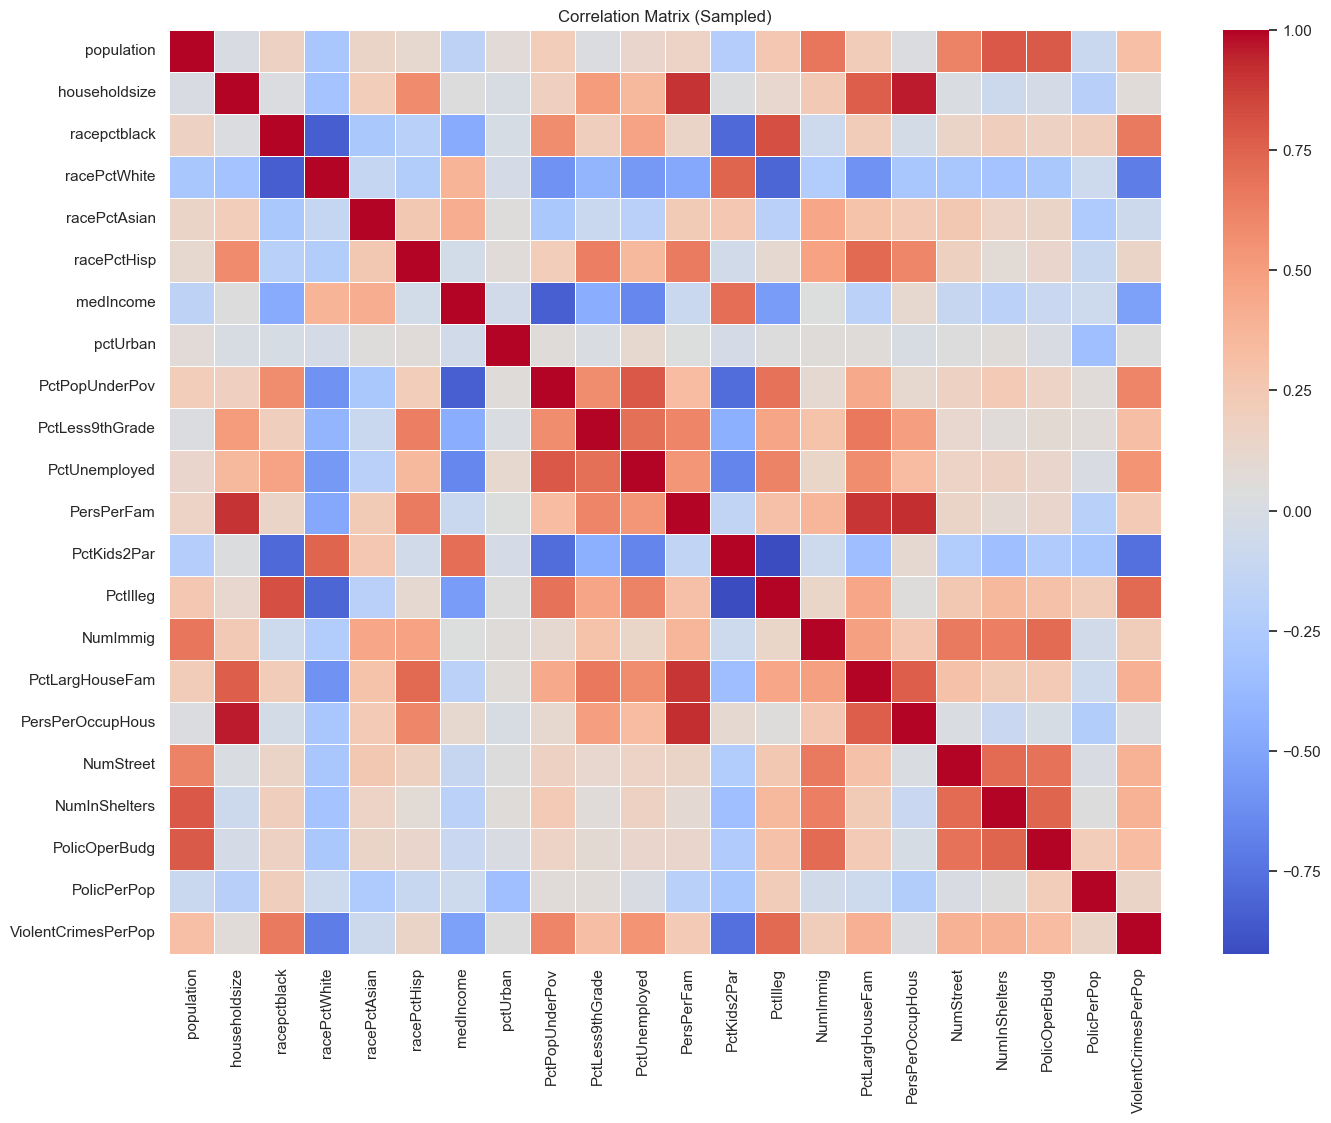

In [234]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
result_df_viz = result_df_viz.toPandas()

# Drop any remaining nulls
result_df_viz.dropna(inplace=True)

# ===========================
# 📊 Correlation Heatmap
# ===========================
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
corr_matrix = result_df_viz.corr(numeric_only=True)

sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Sampled)")
plt.show()


### 🧮 Visualize Crime Rate Distribution
Displays the frequency distribution of the target variable `ViolentCrimesPerPop` using a histogram with a KDE overlay.

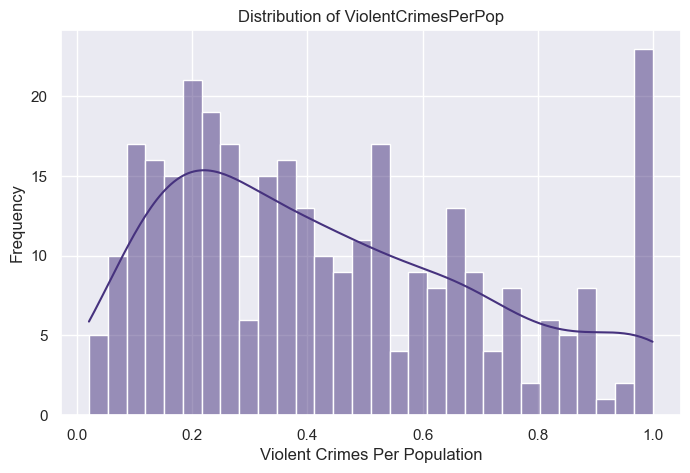

In [235]:
plt.figure(figsize=(8, 5))
sns.histplot(result_df_viz['ViolentCrimesPerPop'], bins=30, kde=True)
plt.title("Distribution of ViolentCrimesPerPop")
plt.xlabel("Violent Crimes Per Population")
plt.ylabel("Frequency")
plt.show()


### 📦 Income Distribution by Crime Level
Visualizes how median income varies across binned crime levels (Low, Medium, High) using a boxplot.

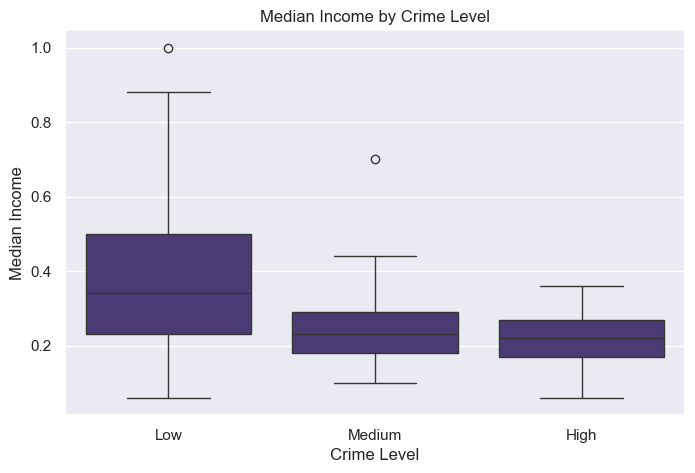

In [236]:
# Create 'crime_level' bin again for pandas
result_df_viz["crime_level"] = pd.cut(
    result_df_viz["ViolentCrimesPerPop"],
    bins=[0, 0.4, 0.7, 1.0],
    labels=["Low", "Medium", "High"]
)

plt.figure(figsize=(8, 5))
sns.boxplot(x="crime_level", y="medIncome", data=result_df_viz)
plt.title("Median Income by Crime Level")
plt.xlabel("Crime Level")
plt.ylabel("Median Income")
plt.show()


### 📈 Scatterplot: Poverty vs Crime
Shows the relationship between poverty rate and violent crime rate using a scatter plot to identify possible trends or clusters.

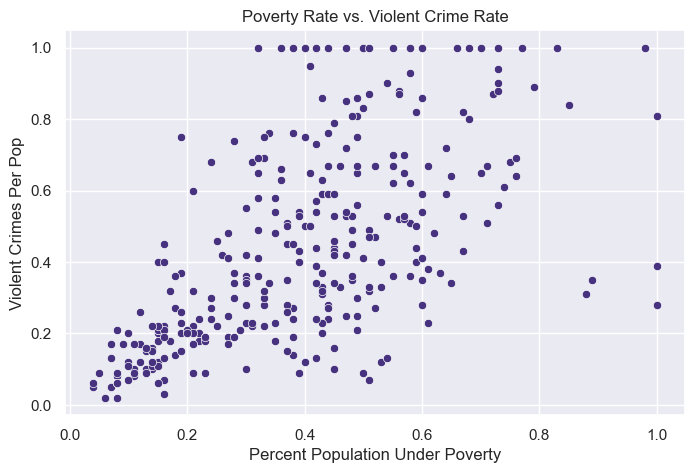

In [237]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="PctPopUnderPov", y="ViolentCrimesPerPop", data=result_df_viz)
plt.title("Poverty Rate vs. Violent Crime Rate")
plt.xlabel("Percent Population Under Poverty")
plt.ylabel("Violent Crimes Per Pop")
plt.show()


## 📊 **SQL-Based Analysis**

### 🧮 Create SQL View for Result DataFrame
Registers the final transformed DataFrame as a temporary SQL view to enable SQL queries for further analysis.

In [238]:
# Create a SQL view from result_df
result_df.createOrReplaceTempView("final_result")

### 🧱 Bin Crime Levels in SQL
Adds a new column `crime_level` by categorizing the `ViolentCrimesPerPop` variable into High, Medium, or Low for easier group analysis.

In [239]:
# Create binned crime levels
spark.sql("""
    SELECT *,
        CASE 
            WHEN ViolentCrimesPerPop >= 0.7 THEN 'High'
            WHEN ViolentCrimesPerPop >= 0.4 THEN 'Medium'
            ELSE 'Low'
        END AS crime_level
    FROM final_result
""").createOrReplaceTempView("binned_result")

### 📊 Summary Stats by Crime Level
Aggregates key socioeconomic indicators (income, poverty, police budget) by crime level to find patterns across different crime intensities.

In [240]:
# Analyze poverty vs crime_level
spark.sql("""
    SELECT crime_level,
        COUNT(*) AS total_communities,
        ROUND(AVG(PctPopUnderPov), 2) AS avg_pct_under_poverty,
        ROUND(AVG(PolicOperBudg), 2) AS avg_police_budget
    FROM binned_result
    GROUP BY crime_level
    ORDER BY crime_level
""").show()

+-----------+-----------------+---------------------+-----------------+
|crime_level|total_communities|avg_pct_under_poverty|avg_police_budget|
+-----------+-----------------+---------------------+-----------------+
|       High|              122|                 0.54|             0.15|
|        Low|             1608|                 0.26|             0.03|
|     Medium|              264|                 0.47|              0.1|
+-----------+-----------------+---------------------+-----------------+



### 🔟 Top 10 Poorest, Most Violent Communities
Lists the top 10 communities with the highest poverty and violent crime rates to highlight potential areas of concern.

In [241]:
spark.sql("""
    SELECT *
    FROM final_result
    WHERE PctPopUnderPov IS NOT NULL AND ViolentCrimesPerPop IS NOT NULL
    ORDER BY PctPopUnderPov DESC, ViolentCrimesPerPop DESC
    LIMIT 10
""").show(truncate=False)

+--------+----------------+-------------+----------+-------------+-----------+-------------+--------------+---------+---------------+-------------------+
|NumImmig|PersPerOccupHous|householdsize|PersPerFam|NumInShelters|PctKids2Par|PolicOperBudg|PctPopUnderPov|medIncome|PctLargHouseFam|ViolentCrimesPerPop|
+--------+----------------+-------------+----------+-------------+-----------+-------------+--------------+---------+---------------+-------------------+
|0.0     |0.7             |0.67         |0.78      |0.0          |0.0        |NULL         |1.0           |0.0      |0.63           |1.0                |
|0.0     |0.5             |0.55         |0.67      |0.01         |0.05       |0.0          |1.0           |0.08     |0.58           |0.81               |
|0.0     |0.54            |0.52         |0.62      |0.0          |0.47       |NULL         |1.0           |0.05     |0.49           |0.61               |
|0.0     |0.54            |0.52         |0.64      |0.0          |0.17      

### 🧭 Crime Rankings by State
Reattaches the preserved `state` column and ranks communities within each state by their violent crime rate using Spark SQL's window functions.

In [242]:
from pyspark.sql.functions import monotonically_increasing_id

# Add row indices to join safely
with_state = tidy_df.withColumn("row_id", monotonically_increasing_id())
with_state_info = state_df.withColumn("row_id", monotonically_increasing_id())
with_state_info = with_state_info.drop("ViolentCrimesPerPop")

# Reattach 'state'
final_df = with_state.join(with_state_info, on="row_id").drop("row_id")
final_df.createOrReplaceTempView("final_with_state")


In [243]:
spark.sql("""
    SELECT *, 
        RANK() OVER (PARTITION BY state ORDER BY ViolentCrimesPerPop DESC) AS crime_rank_in_state
    FROM final_with_state
""").createOrReplaceTempView("crime_ranks_by_state")

spark.sql("""
    SELECT * FROM crime_ranks_by_state
    WHERE crime_rank_in_state = 1
""").show(truncate=False)

+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+------------+-------------+----------------+--------------+

## SparkML Analysis

### 🚀 Model Training and Evaluation

We implemented four regression models using SparkML to predict violent crime rates:
- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient-Boosted Trees Regressor

We evaluated model performance using Root Mean Squared Error (RMSE) on a held-out test set.

### 🛠 Data Split and Evaluator

We split the dataset into training (80%) and testing (20%) sets to evaluate model performance.  
We also defined a regression evaluator using RMSE (Root Mean Squared Error) as our main metric.

In [244]:
# Import SparkML regression models and evaluator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Split the dataset into training (80%) and testing (20%) sets
train_df, test_df = result_df.randomSplit([0.8, 0.2], seed=42)

# Initialize the regression evaluator with RMSE metric
evaluator = RegressionEvaluator(
    labelCol="ViolentCrimesPerPop",    
    predictionCol="prediction",       
    metricName="rmse"                  
)

In [245]:
# Vector assemble the features
assembler2 = VectorAssembler(
    inputCols=columns_to_select_ml[:-1],  # Exclude the target variable
    outputCol="ml_features",
    handleInvalid="skip"
)

train_df = assembler2.transform(train_df)
test_df = assembler2.transform(test_df)

### 🚀 Train and Evaluate Models

We trained four models and evaluated their performance on the test set.  
For each model, we computed the RMSE and printed the results.

In [246]:
# Define the four regression models to evaluate
models = {
    "Linear Regression": LinearRegression(featuresCol='ml_features', labelCol='ViolentCrimesPerPop'),
    "Decision Tree Regressor": DecisionTreeRegressor(featuresCol='ml_features', labelCol='ViolentCrimesPerPop'),
    "Random Forest Regressor": RandomForestRegressor(featuresCol='ml_features', labelCol='ViolentCrimesPerPop'),
    "Gradient Boosted Trees": GBTRegressor(featuresCol='ml_features', labelCol='ViolentCrimesPerPop')
}

# Prepare a list to store model names and RMSE scores
results = []

# Loop over each model, train, predict, and evaluate
for name, model in models.items():
    fitted_model = model.fit(train_df)
    test_predictions = fitted_model.transform(test_df)
    test_rmse = evaluator.evaluate(test_predictions)
    
    train_predictions = fitted_model.transform(train_df)
    train_rmse = evaluator.evaluate(train_predictions)
    
    results.append((name, train_rmse, test_rmse))


25/05/07 15:53:42 WARN Instrumentation: [20a5ee74] regParam is zero, which might cause numerical instability and overfitting.


### Summarize Model Performance

We summarized the RMSE scores in a sorted table to easily identify the best-performing model.

In [247]:
# Import pandas for creating a summary table
import pandas as pd

summary_df = pd.DataFrame(results, columns=['Model', 'Train_RMSE', 'Test_RMSE'])
print(summary_df)

                     Model  Train_RMSE  Test_RMSE
0        Linear Regression    0.169490   0.180857
1  Decision Tree Regressor    0.129294   0.192450
2  Random Forest Regressor    0.127434   0.186742
3   Gradient Boosted Trees    0.045690   0.197036


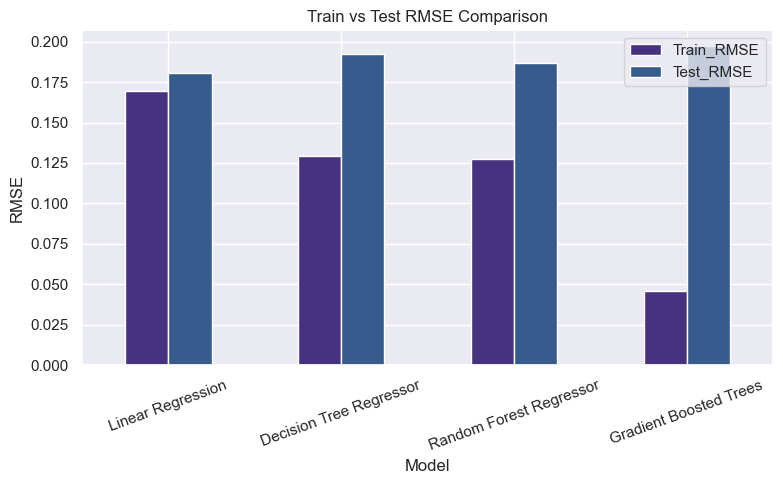

25/05/07 15:53:53 WARN Instrumentation: [16fd8714] regParam is zero, which might cause numerical instability and overfitting.


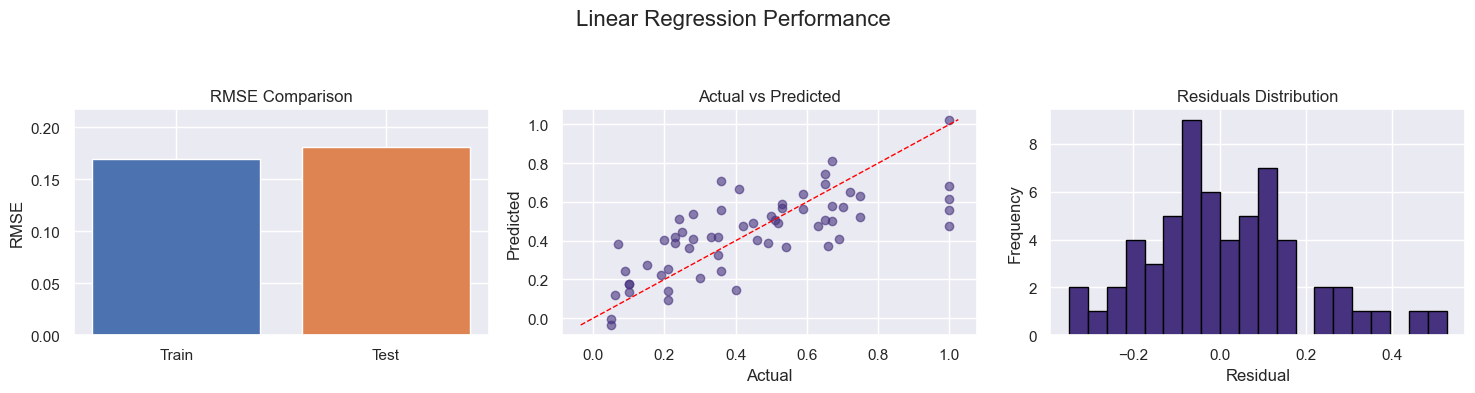

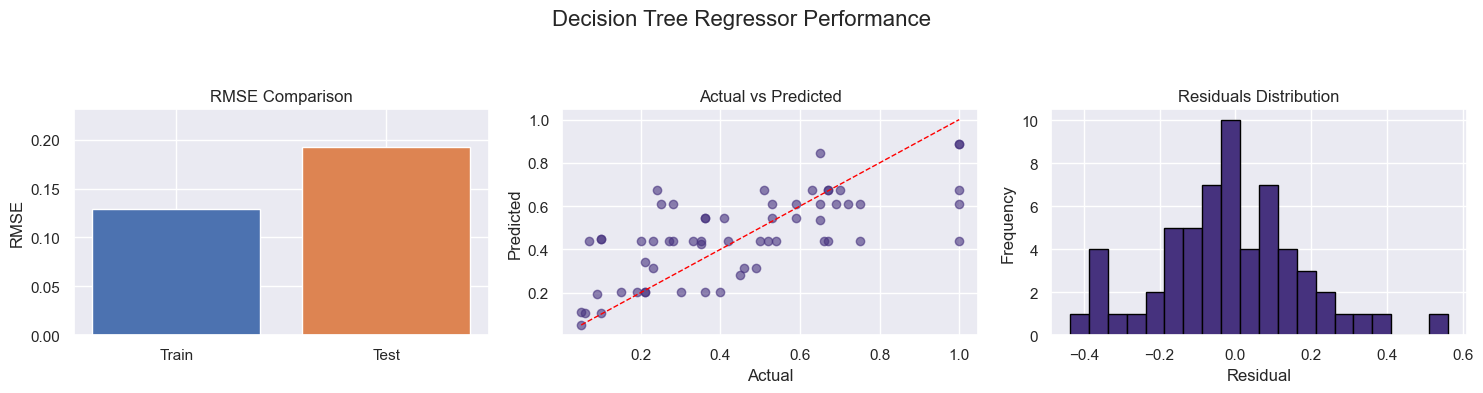

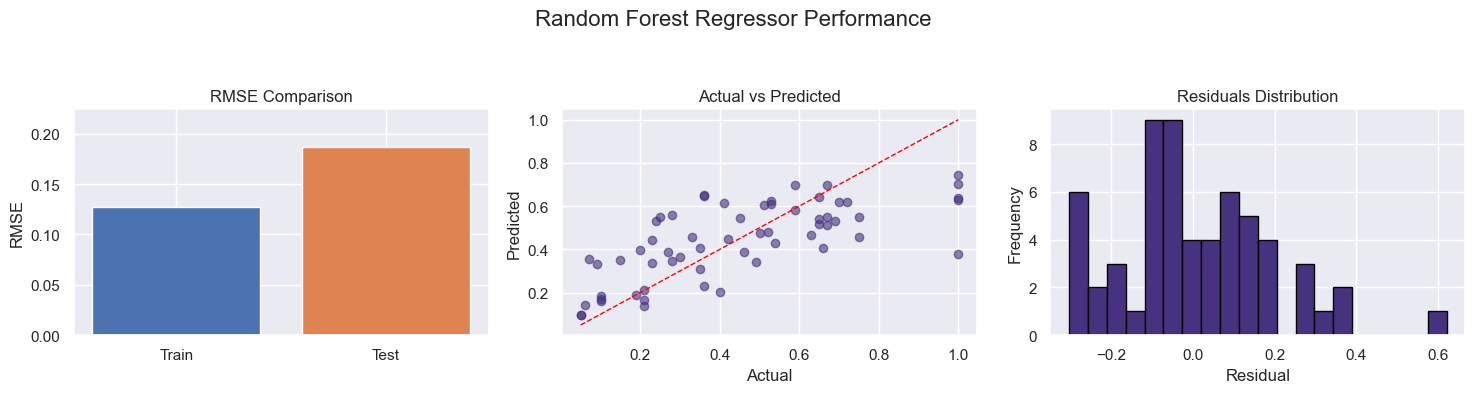

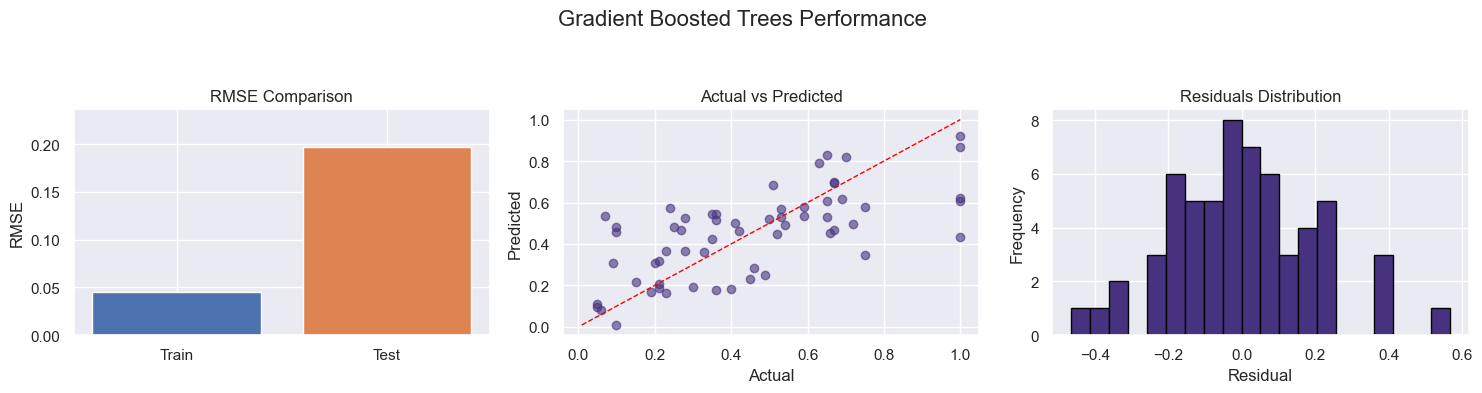

In [248]:
# Bar chart
df_reset = summary_df.reset_index() 
df_reset.plot(
    x='Model', 
    y=['Train_RMSE','Test_RMSE'],
    kind='bar',
    figsize=(8,5),
    rot=20
)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE Comparison")
plt.tight_layout()
plt.show()


for name, train_rmse, test_rmse in results:
    est = models[name]
    fitted = est.fit(train_df)
    test_pred = fitted.transform(test_df)
    pdf = test_pred.select("ViolentCrimesPerPop","prediction").toPandas()
    pdf["residual"] = pdf["ViolentCrimesPerPop"] - pdf["prediction"]

    fig, axes = plt.subplots(1,3,figsize=(15,4))
    fig.suptitle(f"{name} Performance", fontsize=16)

    # RMSE comparison
    axes[0].bar(["Train","Test"], [train_rmse, test_rmse],
                color=['#4C72B0','#DD8452'])
    axes[0].set_ylim(0, max(train_rmse,test_rmse)*1.2)
    axes[0].set_title("RMSE Comparison")
    axes[0].set_ylabel("RMSE")

    # Actual vs Predicted
    axes[1].scatter(pdf["ViolentCrimesPerPop"], pdf["prediction"], alpha=0.6)
    mn, mx = pdf[["ViolentCrimesPerPop","prediction"]].values.min(), pdf[["ViolentCrimesPerPop","prediction"]].values.max()
    axes[1].plot([mn,mx],[mn,mx],"r--",linewidth=1)
    axes[1].set_title("Actual vs Predicted")
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predicted")

    # Residuals
    axes[2].hist(pdf["residual"], bins=20, edgecolor="k")
    axes[2].set_title("Residuals Distribution")
    axes[2].set_xlabel("Residual")
    axes[2].set_ylabel("Frequency")

    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()


### ⚙️ Advanced SparkML Features

We implemented:
- Cross-validation + hyperparameter tuning for Linear Regression using `CrossValidator` and `ParamGridBuilder`.
- Feature importance extraction for Random Forest to interpret which PCA components influence predictions the most.

These advanced techniques improve model robustness and interpretability.

In [249]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Linear Regression model
lr = LinearRegression(featuresCol='ml_features', labelCol='ViolentCrimesPerPop')

# Build parameter grid to test different regularization values
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Set up 5-fold cross-validator
cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5
)

# Run cross-validation on training set
cv_model = cv.fit(train_df)

# Evaluate the best model on the test set
cv_predictions = cv_model.transform(test_df)
cv_rmse = evaluator.evaluate(cv_predictions)

print(f"\nBest Linear Regression (CV) RMSE: {cv_rmse:.4f}")



Best Linear Regression (CV) RMSE: 0.1842


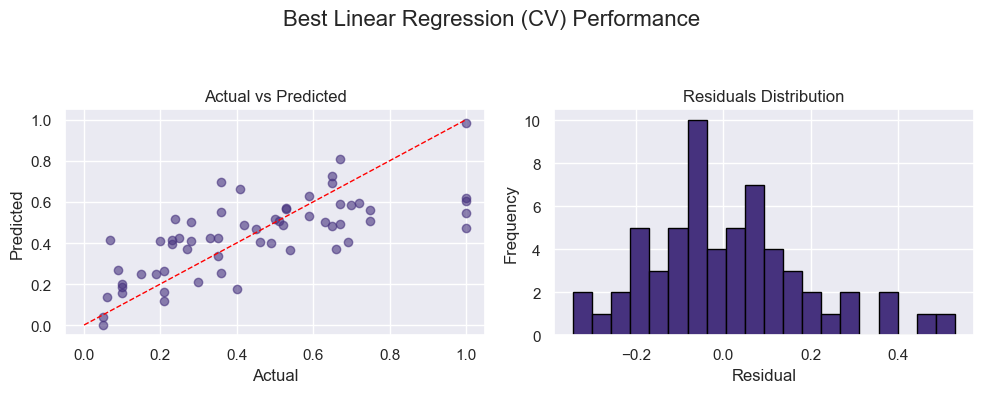

In [255]:
# Convert predictions to Pandas DataFrame
cv_pdf = cv_predictions.select("ViolentCrimesPerPop", "prediction").toPandas()
cv_pdf["residual"] = cv_pdf["ViolentCrimesPerPop"] - cv_pdf["prediction"]

fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle("Best Linear Regression (CV) Performance", fontsize=16)

# Actual vs Predicted
axes[0].scatter(cv_pdf["ViolentCrimesPerPop"], cv_pdf["prediction"], alpha=0.6)
mn, mx = cv_pdf[["ViolentCrimesPerPop", "prediction"]].values.min(), cv_pdf[["ViolentCrimesPerPop", "prediction"]].values.max()
axes[0].plot([mn, mx], [mn, mx], "r--", linewidth=1)
axes[0].set_title("Actual vs Predicted")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")

# Residuals
axes[1].hist(cv_pdf["residual"], bins=20, edgecolor="k")
axes[1].set_title("Residuals Distribution")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
